In [1]:
# Importing useful libraries and functions
## System libraries
from dataclasses import dataclass, field
from typing import Dict, List, Tuple

## Python essential libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
from scipy.optimize import curve_fit
import astropy.units as u
import astropy.constants as const

from lmfit import Model

# Defining my matplotlib canvas template
## For black, set #000000. For navy, set #002060
defaultcolor = '#002060'
plt.rcParams.update({'text.color': defaultcolor, 'axes.labelcolor': defaultcolor, 
                     'xtick.color': defaultcolor, 'ytick.color': defaultcolor,
                     'axes.prop_cycle': cycler(color=['b', 'r', 'limegreen', 'orange']),
                     'font.family':'serif', 'font.serif': 'Times New Roman',
                     'font.size': 22, 'lines.linewidth': 3,
                     'figure.figsize': (9.6, 5.4), 'figure.dpi': 100})

In [2]:
def gaussian(x, A, mu, sigma):
    return A / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - mu)**2 / (2 * sigma)**2)

def powerlaw(x, alpha, Aprime, minval, maxval):
    b = (minval)**(alpha+1)
    c = (maxval)**(alpha+1)
    # Aprime = A * (alpha+1)
    return Aprime * x**(alpha) / (c - b)

In [24]:
# System parameters
A = 35 * u.ph / u.cm**2 / u.s   # Amplitude of peak TODO: Depend on age, distance, and mass - only for Cas A
mu = 1157 * u.keV               # Line emission energy
fwhm = 5.3 * u.keV              # Instrumental line broadening (2.35 keV) # 9.1 keV, required performance; 5.3 keV, projected performance
sigma = fwhm / 2.355            # Converting to sigma, i.e., rms instrumental line broadening

# Background parameters
c = 1 * A.unit / u.keV

# Window of interest
xdata = np.linspace(1140, 1180, 201) * u.keV

In [19]:
binwidth = xdata[1] - xdata[0]
binwidth

<Quantity 0.2 keV>

In [20]:
# Function to calculate Doppler shifts
'''
vs towards the observer is negative
vs away from the observer is positive
For non-relativistic vs speeds
'''
def doppler_shift(E, vs):
    Eprime = const.c / (const.c + vs) * E
    return Eprime - E
    # Eprime = 

# Linearly extrapolated version of Doppler broadening
# TODO: Verify correctness
'''
vmax is the highest absolute velocity of an 
expanding shell in the SN's rest frame
'''
def doppler_broadening(E, vmax):
    # 3.85 keV for 1000 km/s
    # 1.9 keV for 500 km/s
    broadening = 3.85 * u.keV * (vmax / (1000 * u.km/u.s))
    return broadening

In [21]:
E = 1157.02 * u.keV
vs = 1200 * u.km/u.s
E + doppler_shift(E, vs)

<Quantity 1152.4071801 keV>

## Symmetric line profile of homogenous 44Ti clump
About central 1157 keV energy

Brodening due to Doppler broadening

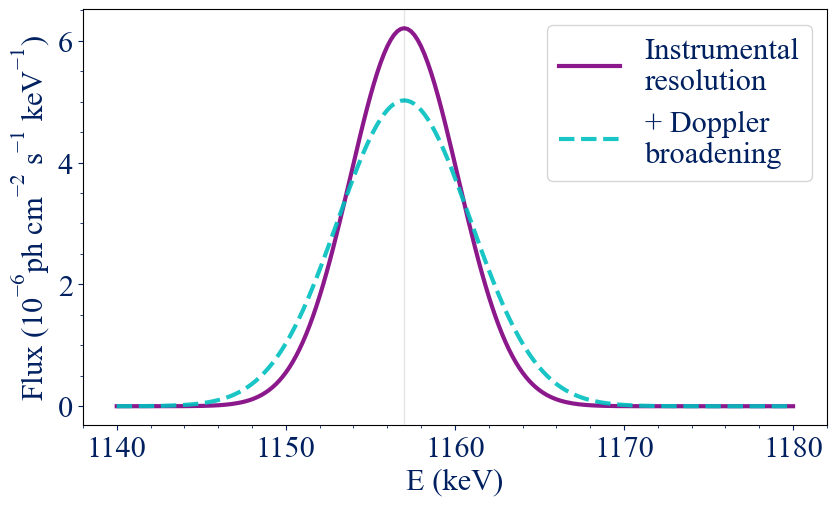

In [112]:
broadening = 0 * u.keV
ydata = gaussian(xdata, A, mu, np.sqrt(sigma**2 + broadening**2)) #+ c
plt.plot(xdata, ydata, label='Instrumental\nresolution', alpha=0.9, c='purple', lw=3)

broadening = 3.85 * u.keV / 2.355   # 3.85 keV corresponds to a Doppler broadening of 1000 km/s   # TODO: Replace broadening scalar value with function
                                    # 1.9 keV corresponds to a Doppler broadening of 500 km/s
ydata = gaussian(xdata, A, mu, np.sqrt(sigma**2 + broadening**2)) #+ c
plt.plot(xdata, ydata, label='+ Doppler\nbroadening', alpha=0.9, c='c', lw=3, ls='--')

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

### Adding white noise

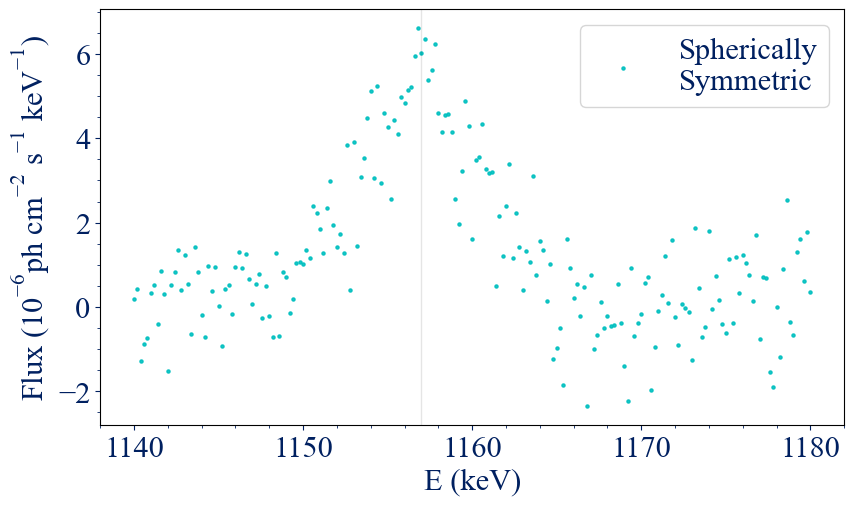

In [32]:
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
plt.scatter(xdata, ydata + whitenoise, label='Spherically\nSymmetric', alpha=0.9, c='c', s=5)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

### Adding Poisson noise

/Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


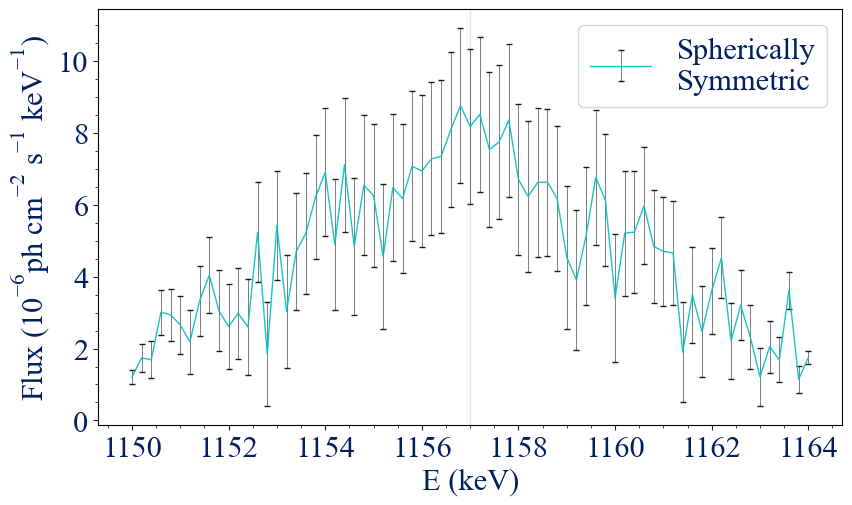

In [33]:
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value      # TODO: This is an inaccurate implementation of Poisson noise
# plt.scatter(xdata, ydata + whitenoise + poissonnoise*c.unit, label='Spherically\nSymmetric', alpha=0.9, c='c', s=5)
plt.errorbar(xdata, ydata + whitenoise + poissonnoise*c.unit, poissonnoise*c.unit, 
             label='Spherically\nSymmetric', alpha=0.9, c='c', lw=1,
             ecolor='k', capsize=2, capthick=1, elinewidth=0.4)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

### Global Doppler shift of entire clump
Although SN is spherically symmetric in its rest frame, there may be a Doppler shift due to motion of the center of mass

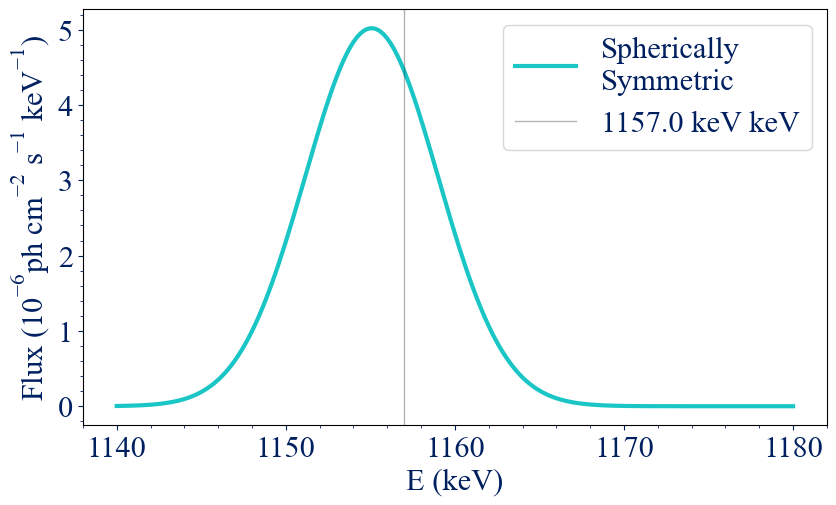

In [34]:
broadening = 3.85 * u.keV / 2.355   # TODO: Replace broadening scalar value with function

vs = +500 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata = gaussian(xdata, A, mu+deltaE, np.sqrt(sigma**2 + broadening**2))
plt.plot(xdata, ydata, label='Spherically\nSymmetric', alpha=0.9, c='c')        # ydata + c

plt.axvline(x=mu.value, alpha=0.3, lw=1, c='k', label=f'{mu} keV')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

### Modifying to power law background

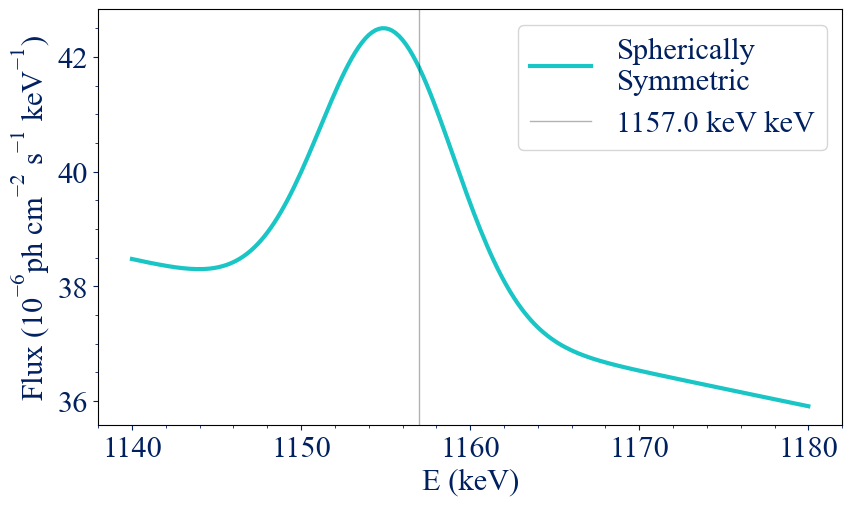

In [35]:
bg = (5e7 * xdata**(-2)).value * c.unit #+ c
plt.plot(xdata, ydata + bg, label='Spherically\nSymmetric', alpha=0.9, c='c')

plt.axvline(x=mu.value, alpha=0.3, lw=1, c='k', label=f'{mu} keV')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

### Adding back the noises

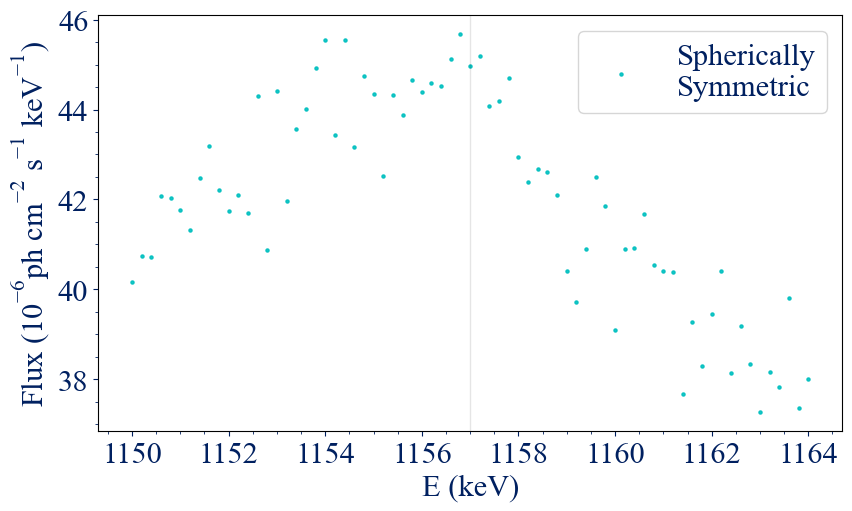

In [36]:
plt.scatter(xdata, ydata + bg + whitenoise + poissonnoise*c.unit, label='Spherically\nSymmetric', alpha=0.9, c='c', s=5)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

## Asymmetries due to inhomogenous/irregular inner yield distribution
Simple two clump model with different amplitudes. Not spatially resolved.

The cause of such irregularities may very well be due to fallback or alpha freeze-out (see next section)

### Non-Doppler broadened scenario
Only contains intrinsic line broadening such as pressure broadening

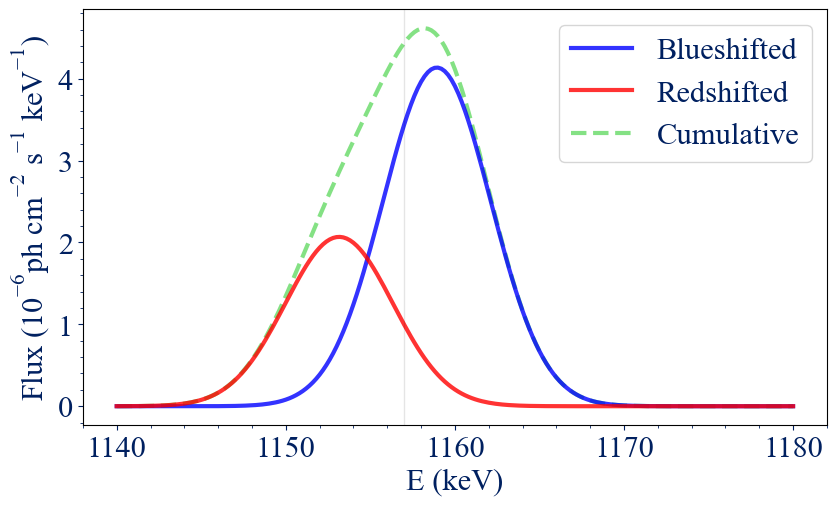

In [74]:
broadening = 0 * u.keV

# Clump 1
'''
Contains 2/3 of total 44Ti yield
Doppler shifted towards from the observer (blueshifted)
Has energy higher than 1157 keV
'''
vs = -500 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata1 = gaussian(xdata, 2/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata1, label=f'Blueshifted', alpha=0.8)

# Clump 2
'''
Contains 1/3 of total 44Ti yield
Doppler shifted away from the observer (redshifted)
Has energy lower than 1157 keV
'''
vs = +1000 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata2 = gaussian(xdata, 1/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata2, label=f'Redshifted', alpha=0.8)

# Cumulative distribution
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', zorder=1) 

# Attempting a single Gaussian fit

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.title('No ')
plt.legend()
plt.show()

### Doppler-broadened scenario

/Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


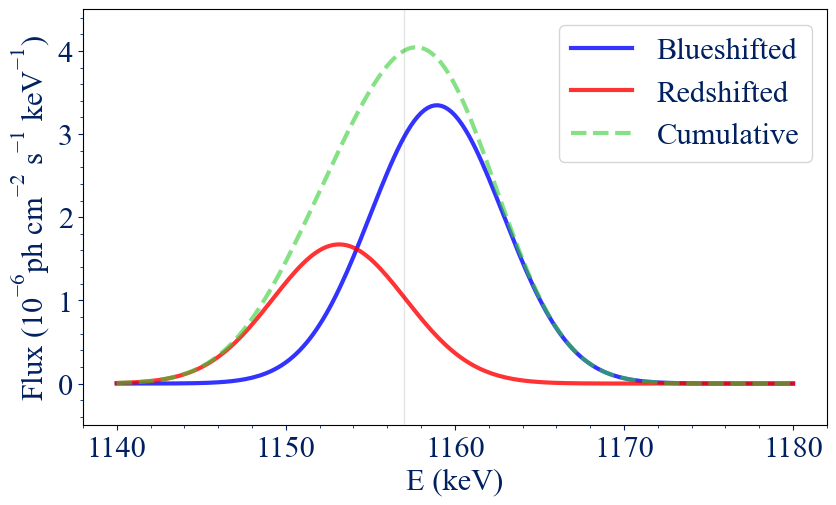

In [96]:
broadening = 3.85 * u.keV / 2.355   # TODO: Replace broadening scalar value with function

# Clump 1
'''
Contains 2/3 of total 44Ti yield
Doppler shifted towards from the observer (blueshifted)
Has energy higher than 1157 keV
'''
vs = -500 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata1 = gaussian(xdata, 2/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata1, label=f'Blueshifted', alpha=0.8)

# Clump 2
'''
Contains 1/3 of total 44Ti yield
Doppler shifted away from the observer (redshifted)
Has energy lower than 1157 keV
'''
vs = +1000 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata2 = gaussian(xdata, 1/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata2, label=f'Redshifted', alpha=0.8)

# Cumulative distribution
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', zorder=2)

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
# plt.scatter(xdata, ydata + whitenoise, label=f'+ Noise', alpha=0.1, c='k', s=3, zorder=1)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
# plt.title('Unresolved')
plt.ylim([-0.5,4.5])
plt.legend()
plt.show()

### Attempting a single Gaussian fit to the cumulative

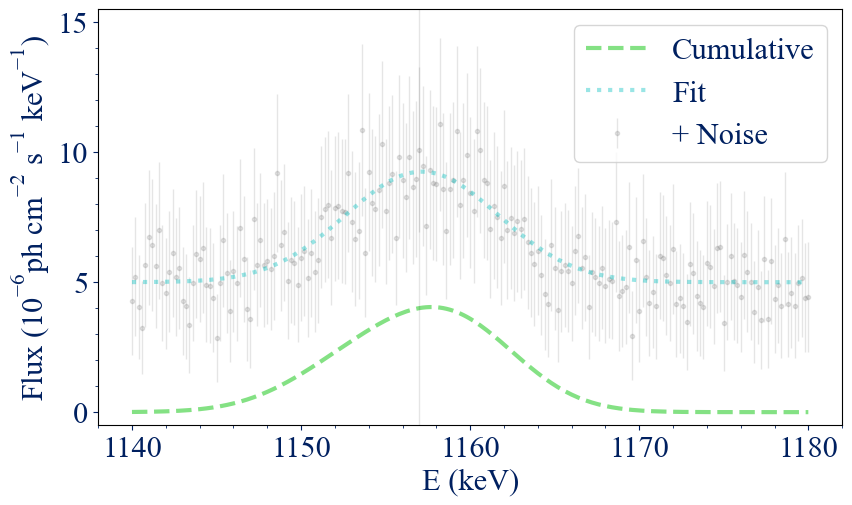

In [98]:
# Cumulative distribution (Includes a y-offset)
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', c='limegreen')

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
plt.errorbar(xdata, ydata + whitenoise + 5*ydata.unit, np.sqrt((ydata + whitenoise).value + 5) * ydata.unit, label=f'+ Noise', alpha=0.1, c='k', fmt='o', ms=3, zorder=1, lw=1)

# Attempting a single Gaussian fit
popt, pcov = curve_fit(gaussian, xdata.value, (ydata + whitenoise).value, 
                       p0=[A.value, mu.value, (sigma+broadening).value])
# Plotting the curve fit
plt.plot(xdata, gaussian(xdata.value, *popt) + 5, label='Fit', alpha=0.4, ls='dotted', c='c')       # gaussian(xdata.value, *popt) + c.value

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.ylim([-0.5,15.5])
# plt.title('Unresolved')
plt.legend()
plt.show()

### Stronger Asymmetries (1.2x)

/Users/penguin/miniconda3/envs/cosipy/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


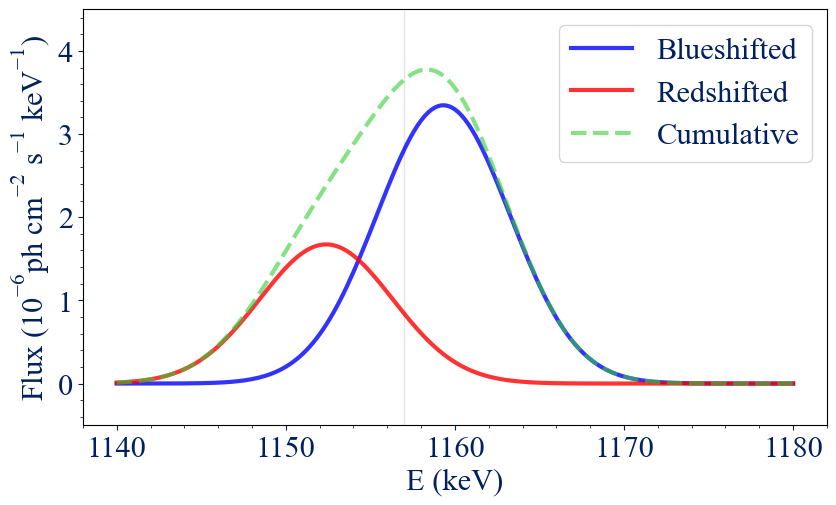

In [99]:
broadening = 3.85 * u.keV / 2.355   # TODO: Replace broadening scalar value with function

# Clump 1
'''
Contains 2/3 of total 44Ti yield
Doppler shifted towards from the observer (blueshifted)
Has energy higher than 1157 keV
'''
vs = -600 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata1 = gaussian(xdata, 2/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata1, label=f'Blueshifted', alpha=0.8)

# Clump 2
'''
Contains 1/3 of total 44Ti yield
Doppler shifted away from the observer (redshifted)
Has energy lower than 1157 keV
'''
vs = +1200 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata2 = gaussian(xdata, 1/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata2, label=f'Redshifted', alpha=0.8)

# Cumulative distribution
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', zorder=2)

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
# plt.scatter(xdata, ydata + whitenoise, label=f'+ Noise', alpha=0.1, c='k', s=3, zorder=1)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.ylim([-0.5,4.5])
plt.legend()
plt.show()

### Attempting a single Gaussian fit to the cumulative

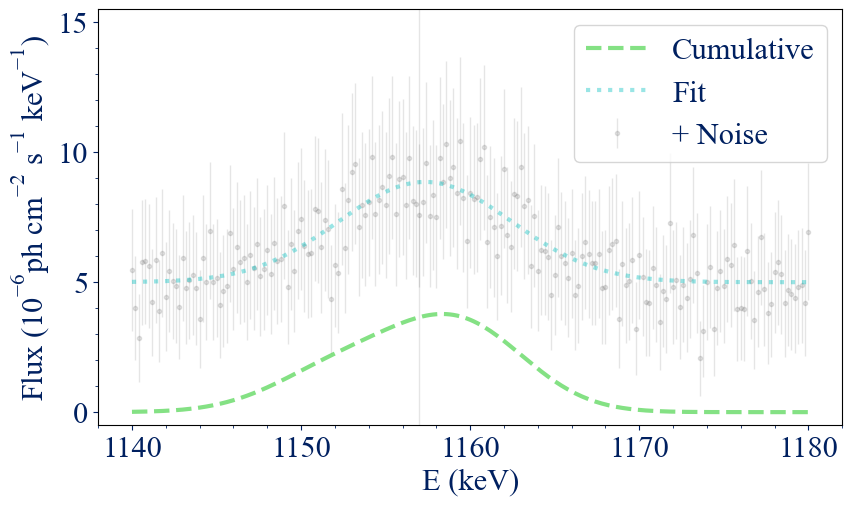

In [100]:
# Cumulative distribution (Includes a y-offset)
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', c='limegreen')

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
plt.errorbar(xdata, ydata + whitenoise + 5*ydata.unit, np.sqrt((ydata + whitenoise).value + 5) * ydata.unit, label=f'+ Noise', alpha=0.1, c='k', fmt='o', ms=3, zorder=1, lw=1)

# Attempting a single Gaussian fit
popt, pcov = curve_fit(gaussian, xdata.value, (ydata + whitenoise).value, 
                       p0=[A.value, mu.value, (sigma+broadening).value])
# Plotting the curve fit
plt.plot(xdata, gaussian(xdata.value, *popt) + 5, label='Fit', alpha=0.4, ls='dotted', c='c')       # gaussian(xdata.value, *popt) + c.value

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.ylim([-0.5,15.5])
plt.legend()
plt.show()

### Even stronger asymmetries (2x)

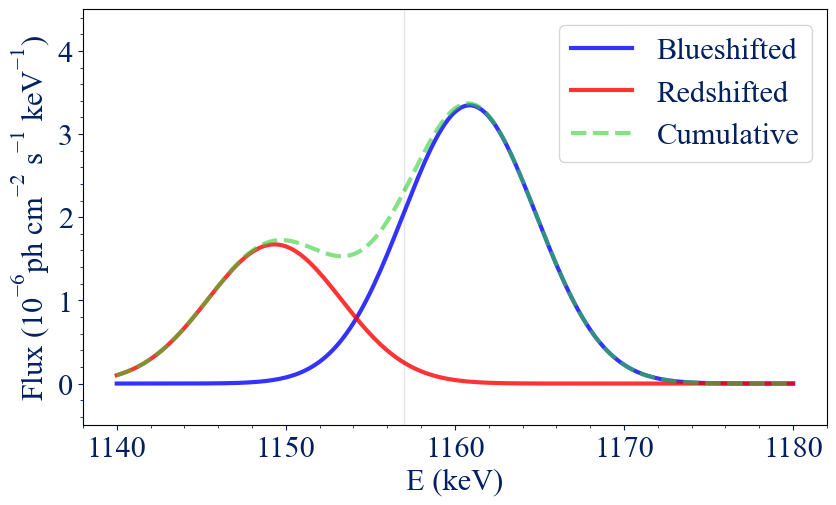

In [101]:
broadening = 3.85 * u.keV / 2.355   # TODO: Replace broadening scalar value with function

# Clump 1
'''
Contains 2/3 of total 44Ti yield
Doppler shifted towards from the observer (blueshifted)
Has energy higher than 1157 keV
'''
vs = -1000 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata1 = gaussian(xdata, 2/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata1, label=f'Blueshifted', alpha=0.8)

# Clump 2
'''
Contains 1/3 of total 44Ti yield
Doppler shifted away from the observer (redshifted)
Has energy lower than 1157 keV
'''
vs = +2000 * u.km / u.s
deltaE = doppler_shift(mu, vs)      # Calculate Doppler shift
ydata2 = gaussian(xdata, 1/3 * A, mu+deltaE, np.sqrt(sigma**2 + broadening**2)) #+ c  # Signal + background
plt.plot(xdata, ydata2, label=f'Redshifted', alpha=0.8)

# Cumulative distribution
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', zorder=2)

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
# plt.scatter(xdata, ydata + whitenoise, label=f'+ Noise', alpha=0.1, c='k', s=3, zorder=1)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.ylim([-0.5,4.5])
plt.legend()
plt.show()

### Attempting a single Gaussian fit to the cumulative

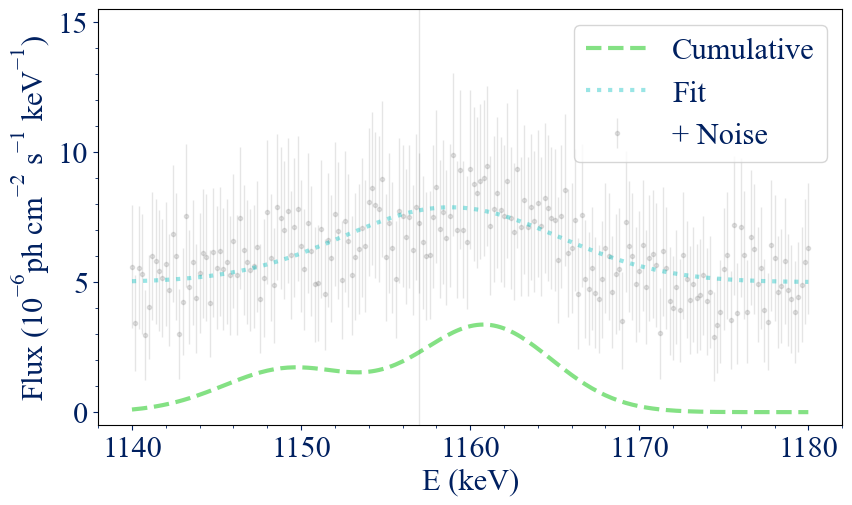

In [102]:
# Cumulative distribution (Includes a y-offset)
ydata = ydata1 + ydata2 #- c       # Subtracting off the background to avoid double-counting (as both ydata1 and 2 have them already)
plt.plot(xdata, ydata, label=f'Cumulative', alpha=0.6, ls='--', c='limegreen')

# Adding noise
whitenoise = np.random.normal(0, 1, len(xdata)) * c.unit
poissonnoise = np.sqrt((ydata - c) * xdata/1000).value
plt.errorbar(xdata, ydata + whitenoise + 5*ydata.unit, np.sqrt((ydata + whitenoise).value + 5) * ydata.unit, label=f'+ Noise', alpha=0.1, c='k', fmt='o', ms=3, zorder=1, lw=1)

# Attempting a single Gaussian fit
popt, pcov = curve_fit(gaussian, xdata.value, (ydata + whitenoise).value, 
                       p0=[A.value, mu.value, (sigma+broadening).value])
# Plotting the curve fit
plt.plot(xdata, gaussian(xdata.value, *popt) + 5, label='Fit', alpha=0.4, ls='dotted', c='c')       # gaussian(xdata.value, *popt) + c.value

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.ylim([-0.5,15.5])
plt.legend()
plt.show()

---------

## Asymmetries due to "missing" clumps
Fallback (onto compact object), local alpha freeze-out (due to temperature, density variations)

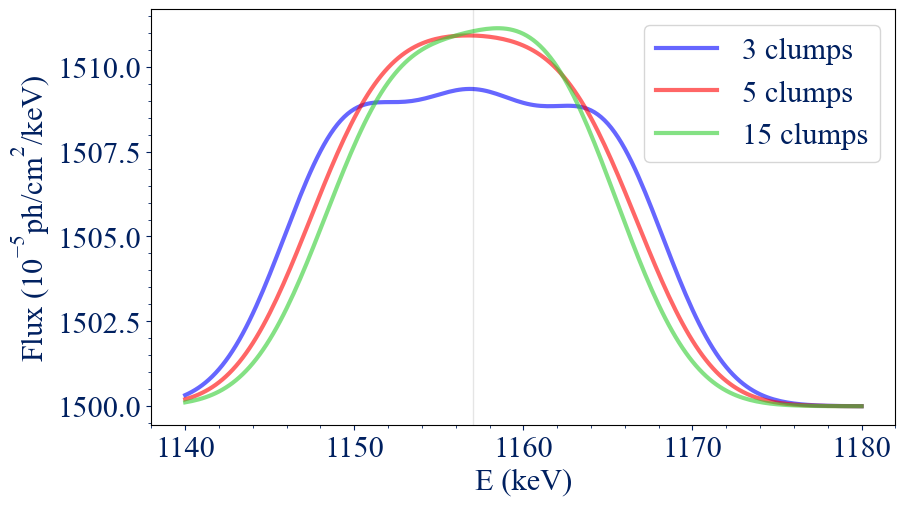

In [19]:
broadening = 3.85 * u.keV / 2.355
# plt.plot(x, gaussian(x, A, mu, np.sqrt(sigma**2 + broadening**2)) + c, label='sph sym', alpha=0.6)

# broadening = 0 * u.keV
vrange = 2000
for n in [3, 5, 15]:
    vs = np.linspace(-vrange, vrange, n) * u.km / u.s       # TODO: vs does not have to be uniformly sampled
    deltaE = doppler_shift(mu, vs)
    ydata = c.value
    for i in range(n):
        # Adding a gap in the vrange
        if vs[i].value < 500 and vs[i].value > 200:
            continue
        ydata += gaussian(xdata, A/n, mu+deltaE[i], np.sqrt(sigma**2 + broadening**2)).value       # Partitioning total energy equally among clumps A/n
    plt.plot(xdata, ydata, label=f'{n} clumps', alpha=0.6)

plt.axvline(x=mu.value, alpha=0.1, lw=1, c='k')
plt.xlabel('E (keV)')
plt.ylabel('Flux ($\mathregular{10^{-6}}$ph cm$\mathregular{^{-2}}$ s$\mathregular{^{-1}}$ keV$\mathregular{^{-1}}$)')
plt.minorticks_on()
plt.legend()
plt.show()

----------

In [107]:
from lmfit.models import GaussianModel, LinearModel, ConstantModel

In [ ]:
peak1 = GaussianModel(prefix='p1_')
pars1 = peak1.make_params(amplitude = A.value, center = mu.value, sigma = sigma.value)
pars1